# Extrinsinc Analysis

In [47]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import networkx as nx
import numpy as np
import yaml
import matplotlib.pyplot as plt
import contextily as cx
import json
from src import graph_functions as gf
from src import simplification_functions as sf
from src import evaluation_functions as ef
from src import matching_functions as mf

In [2]:
with open(r'../config.yml') as file:

    parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)

    study_area = parsed_yaml_file['study_area']
    study_area_poly_fp = parsed_yaml_file['study_area_poly']
    study_crs = parsed_yaml_file['study_crs']

    missing_tag_dict = parsed_yaml_file['missing_tag_analysis']

    incompatible_tags_dict = parsed_yaml_file['incompatible_tags_analysis']

    cycling_infrastructure_queries = parsed_yaml_file['cycling_infrastructure_queries']

    reference_geometries = parsed_yaml_file['reference_geometries']
    cycling_bidirectional = parsed_yaml_file['bidirectional']

    feature_matching = parsed_yaml_file['feature_matching']
    
print('Settings loaded!')

Settings loaded!


### Data Processing

**Load OSM and reference graphs and grid:**

In [3]:
# Load simplified and non-simplified graphs

osm_graph = ox.load_graphml(f'../data/osm_{study_area}.graphml')
osm_simplified_graph = ox.load_graphml(f'../data/osm_{study_area}_simple.graphml')

# Convert to nodes and edges
osm_nodes, osm_edges = ox.graph_to_gdfs(osm_graph)
osm_simplified_nodes, osm_simplified_edges = ox.graph_to_gdfs(osm_simplified_graph)

# Fix converted boolean values
osm_simplified_edges.loc[osm_simplified_edges.cycling_bidirectional=='True','cycling_bidirectional'] = True
osm_simplified_edges.loc[osm_simplified_edges.cycling_bidirectional=='False','cycling_bidirectional'] = False

osm_edges.loc[osm_edges.cycling_bidirectional=='True','cycling_bidirectional'] = True
osm_edges.loc[osm_edges.cycling_bidirectional=='False','cycling_bidirectional'] = False

# Measure the length of cycling infrastructure (!=from length of edge geometries)
osm_simplified_edges['infrastructure_length'] = osm_simplified_edges.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                    geometry_type=x.cycling_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure=x.cycling_infrastructure), axis=1)


# Load simplified and non-simplified graphs
ref_graph = ox.load_graphml(f'../data/ref_{study_area}.graphml')
ref_simplified_graph = ox.load_graphml(f'../data/ref_{study_area}_simple.graphml')

# Convert to nodes and ref_edges
ref_nodes, ref_edges = ox.graph_to_gdfs(ref_graph)
ref_simplified_nodes, ref_simplified_edges = ox.graph_to_gdfs(ref_simplified_graph)

# Fix converted boolean values
if cycling_bidirectional in ref_simplified_edges.columns:
    ref_simplified_edges.loc[ref_simplified_edges.cycling_bidirectional=='True','cycling_bidirectional'] = True
    ref_simplified_edges.loc[ref_simplified_edges.cycling_bidirectional=='False','cycling_bidirectional'] = False

    ref_edges.loc[ref_edges.cycling_bidirectional=='True','cycling_bidirectional'] = True
    ref_edges.loc[ref_edges.cycling_bidirectional=='False','cycling_bidirectional'] = False

# Measure the length of cycling infrastructure (!=from length of edge geometries)
ref_simplified_edges['infrastructure_length'] = ref_simplified_edges.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                        geometry_type=reference_geometries, bidirectional=cycling_bidirectional, cycling_infrastructure='yes'), axis=1)

# Load grid
grid = gpd.read_file(f'../data/grid_{study_area}.gpkg')

grid_ids = grid.grid_id.to_list()

print('Data loaded!')

# Data formatting

# TODO: Convert to function?
# creating coulumns with node id and indexes (required by some functions)
osm_simplified_edges['edge_id'] = osm_simplified_edges.reset_index().index
osm_edges['edge_id'] = osm_edges.reset_index().index

osm_id_dict = osm_simplified_edges['edge_id'].to_dict()
nx.set_edge_attributes(osm_simplified_graph, osm_id_dict, "edge_id")

u_list = osm_simplified_edges.reset_index()['u'].to_list()
v_list = osm_simplified_edges.reset_index()['v'].to_list()
osm_simplified_edges['u'] = u_list
osm_simplified_edges['v'] = v_list

u_list = osm_edges.reset_index()['u'].to_list()
v_list = osm_edges.reset_index()['v'].to_list()
osm_edges['u'] = u_list
osm_edges['v'] = v_list

osm_simplified_nodes['node_id'] = osm_simplified_nodes.index
osm_nodes['node_id'] = osm_nodes.index

# creating coulumns with node id and indexes (required by some functions)
ref_simplified_edges['edge_id'] = ref_simplified_edges.reset_index().index
ref_edges['edge_id'] = ref_edges.reset_index().index

ref_id_dict = ref_simplified_edges['edge_id'].to_dict()
nx.set_edge_attributes(ref_simplified_graph, ref_id_dict, "edge_id")

u_list = ref_simplified_edges.reset_index()['u'].to_list()
v_list = ref_simplified_edges.reset_index()['v'].to_list()
ref_simplified_edges['u'] = u_list
ref_simplified_edges['v'] = v_list

u_list = ref_edges.reset_index()['u'].to_list()
v_list = ref_edges.reset_index()['v'].to_list()
ref_edges['u'] = u_list
ref_edges['v'] = v_list

ref_simplified_nodes['node_id'] = ref_simplified_nodes.index
ref_nodes['node_id'] = ref_nodes.index


Data loaded!


<AxesSubplot:>

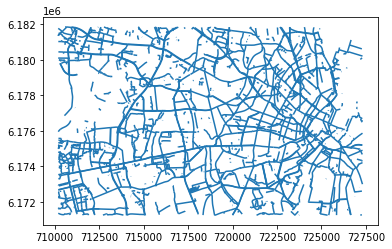

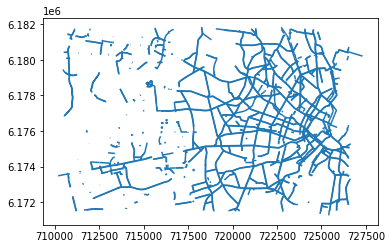

In [4]:
# TODO: Plot
osm_simplified_edges.plot()

# TODO: Plot
ref_simplified_edges.plot()

**Joining grid cell id to network elements and counting features in each grid:**

In [5]:
osm_edges_s_j = gpd.overlay(osm_simplified_edges, grid, how ='intersection')
osm_edges_j = gpd.overlay(osm_edges, grid, how='intersection')

osm_nodes_s_j = gpd.overlay(osm_simplified_nodes, grid, how ='intersection')
osm_nodes_j = gpd.overlay(osm_nodes, grid, how='intersection')

# Count features in each grid cell
all_data = [osm_edges_j,  osm_nodes_j, osm_edges_s_j, osm_nodes_s_j]
labels = ['osm_edges','osm_nodes','osm_simplified_edges','osm_simplified_nodes']

for data, label in zip(all_data, labels):

    df = ef.count_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how='left')

ref_edges_s_j = gpd.overlay(ref_simplified_edges, grid, how ='intersection')
ref_edges_j = gpd.overlay(ref_edges, grid, how='intersection')

ref_nodes_s_j = gpd.overlay(ref_simplified_nodes, grid, how ='intersection')
ref_nodes_j = gpd.overlay(ref_nodes, grid, how='intersection')

# Count features in each grid cell
all_data = [ref_edges_j,  ref_nodes_j, ref_edges_s_j, ref_nodes_s_j]
labels = ['ref_edges','ref_nodes','ref_simplified_edges','ref_simplified_nodes']

for data, label in zip(all_data, labels):

    df = ef.count_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how='left')

/var/folders/ps/s7wb5z895tg8mfmxb_xbb_bm0000gn/T/ipykernel_13262/534589838.py:17: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ref_edges_s_j = gpd.overlay(ref_simplified_edges, grid, how ='intersection')
/var/folders/ps/s7wb5z895tg8mfmxb_xbb_bm0000gn/T/ipykernel_13262/534589838.py:18: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ref_edges_j = gpd.overlay(ref_edges, grid, how='intersection')


## Data Completeness

**How much is mapped in the different datasets?**

**Comparing network length:**

In [6]:
ref_length = ref_simplified_edges.infrastructure_length.sum()

osm_length = osm_simplified_edges.infrastructure_length.sum()

diff = abs(osm_length - ref_length)

percent_diff = (osm_length - ref_length) / osm_length * 100

# TODO: Add plot visualising lenght difference

print(f'There is an {diff/1000:.2f} km length difference between the two datasets')

print(f'The difference between the length of the OSM and the reference data is {percent_diff:.2f} %')

There is an 435.98 km length difference between the two datasets
The difference between the length of the OSM and the reference data is 41.15 %


**Comparing number of nodes and edges:**

Is this interesting? Does not say that much in itself.

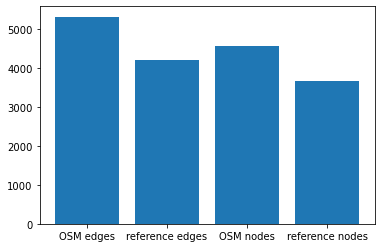

In [7]:
osm_nodes_count = len(osm_simplified_nodes)
osm_edges_count = len(osm_simplified_edges)

ref_nodes_count = len(ref_simplified_nodes)
ref_edges_count = len(ref_simplified_edges)

# TODO: format plot
values = [osm_edges_count, ref_edges_count, osm_nodes_count, ref_nodes_count]
labels = ['OSM edges','reference edges', 'OSM nodes', 'reference nodes']

plt.bar(range(len(values)), values, tick_label=labels);

# TODO Number of edges and nodes per network length?

**Comparing network density:**

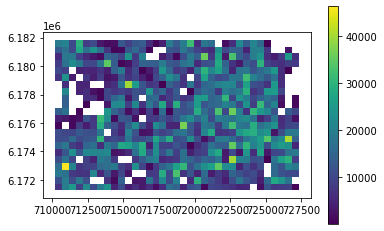

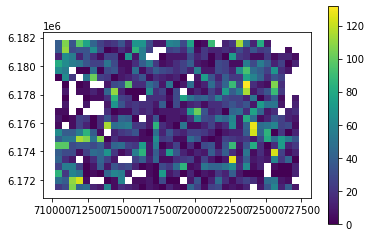

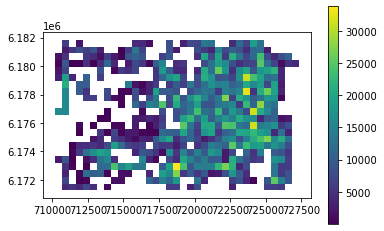

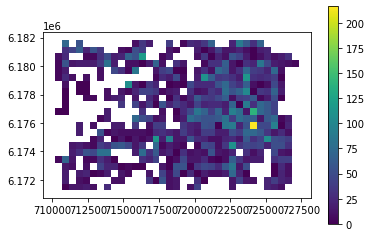

In [8]:
results_dict = {}
area = grid.loc[0,'geometry'].area
data = (osm_edges_s_j, osm_nodes_s_j)
[ef.run_grid_analysis(grid_id, data, results_dict, ef.compute_network_density, area) for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df.reset_index(inplace=True)
results_df.rename(columns={'index':'grid_id', 0:'osm_edge_density',1:'osm_node_density'}, inplace=True)

grid = grid.merge(results_df, on='grid_id', how='left')

# TODO: Format plotting
grid.plot(column='osm_edge_density', legend=True)
grid.plot(column='osm_node_density', legend=True)


results_dict = {}
area = grid.loc[0,'geometry'].area
data = (ref_edges_s_j, ref_nodes_s_j)
[ef.run_grid_analysis(grid_id, data, results_dict, ef.compute_network_density, area) for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df.reset_index(inplace=True)
results_df.rename(columns={'index':'grid_id', 0:'ref_edge_density',1:'ref_node_density'}, inplace=True)

grid = grid.merge(results_df, on='grid_id', how='left')

# TODO: Format plotting
grid.plot(column='ref_edge_density', legend=True);
grid.plot(column='ref_node_density', legend=True);


**Differences in network density:**

<AxesSubplot:>

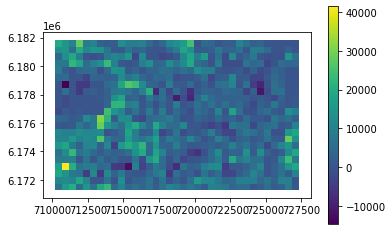

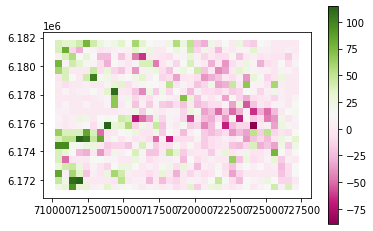

In [9]:
grid['edge_density_diff'] = grid.osm_edge_density.fillna(value=0) - grid.ref_edge_density.fillna(value=0)
grid['node_density_diff'] = grid.osm_node_density.fillna(value=0) - grid.ref_node_density.fillna(value=0)


# TODO: Format plotting OBS! If they go below zero, as with node diff here, this should be emphasized!
grid.plot(column='edge_density_diff', legend=True)
grid.plot(column='node_density_diff', legend=True, cmap='PiYG')

**Differences in density between protected/unprotected cycling infrastructure:**

In [10]:
osm_protected = osm_edges_s_j.loc[osm_edges_s_j.protected=='protected']
osm_unprotected = osm_edges_s_j.loc[osm_edges_s_j.protected=='unprotected']
osm_mixed = osm_edges_s_j.loc[osm_edges_s_j.protected=='mixed']

ref_protected = ref_edges_s_j.loc[ref_edges_s_j.protected=='protected']
ref_unprotected = ref_edges_s_j.loc[ref_edges_s_j.protected=='unprotected']
ref_mixed = ref_edges_s_j.loc[ref_edges_s_j.protected=='mixed']

osm_data = [osm_protected, osm_unprotected, osm_mixed]
ref_data = [ref_protected, ref_unprotected, ref_mixed]

osm_labels = ['osm_protected_density', 'osm_unprotected_density','osm_mixed_density']
ref_labels = ['ref_protected_density', 'ref_unprotected_density','ref_mixed_density']

for data, label in zip(osm_data, osm_labels):
    if len(data) > 0:
        results_dict = {}
        area = grid.loc[0,'geometry'].area
        data = (osm_edges_s_j.loc[data.index], osm_nodes_s_j)
        [ef.run_grid_analysis(grid_id, data, results_dict, ef.compute_network_density, area) for grid_id in grid_ids];

        results_df = pd.DataFrame.from_dict(results_dict, orient='index')
        results_df.reset_index(inplace=True)
        results_df.rename(columns={'index':'grid_id', 0:label}, inplace=True)
        results_df.drop(1,axis=1,inplace=True)

        grid = grid.merge(results_df, on='grid_id', how='left')

for data, label in zip(ref_data, ref_labels):
    if len(data) > 0:
        results_dict = {}
        area = grid.loc[0,'geometry'].area
        data = (osm_edges_s_j.loc[data.index], osm_nodes_s_j)
        [ef.run_grid_analysis(grid_id, data, results_dict, ef.compute_network_density, area) for grid_id in grid_ids];

        results_df = pd.DataFrame.from_dict(results_dict, orient='index')
        results_df.reset_index(inplace=True)
        results_df.rename(columns={'index':'grid_id', 0:label}, inplace=True)
        results_df.drop(1,axis=1,inplace=True)

        grid = grid.merge(results_df, on='grid_id', how='left')


grid['protected_density_diff'] = grid.osm_protected_density.fillna(value=0) - grid.ref_protected_density.fillna(value=0)
grid['unprotected_density_diff'] = grid.osm_unprotected_density.fillna(value=0) - grid.ref_unprotected_density.fillna(value=0)

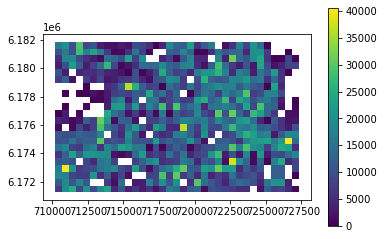

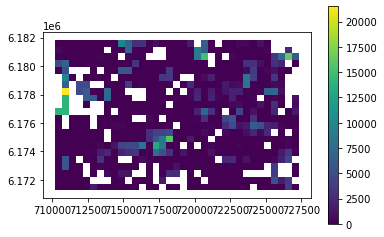

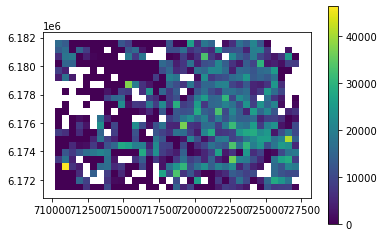

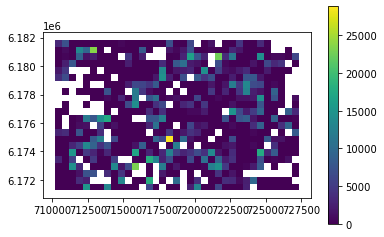

In [38]:
grid.plot(column='osm_protected_density', legend=True)
grid.plot(column='osm_unprotected_density', legend=True)

grid.plot(column='ref_protected_density', legend=True)
grid.plot(column='ref_unprotected_density', legend=True);

**Positive values indicate that the OSM density of the infrastructure type is higher than the reference density, negative values that the OSM density is lower.**

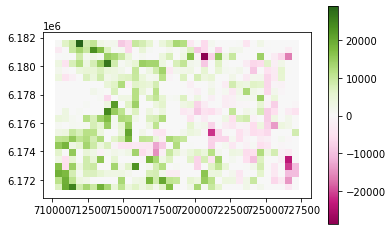

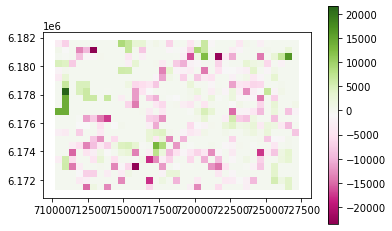

In [39]:
# TODO: Format plotting OBS! If they go below zero, as with node diff here, this should be emphasized!

grid.plot(column='protected_density_diff', legend=True, cmap='PiYG')
grid.plot(column='unprotected_density_diff', legend=True, cmap='PiYG');

**Spatial distribution of network length differences:**

In [15]:
# TODO: Analysis of network length and density comparison

# What is the correlation between edge and node density? E.g. perfect correlation, might just be a question of more/less mapped features
# If not a perfect relationship - indicates differences in network structure

# Analyse if grid cells with a high or low value are clustered
# Is pattern random?

## Data Quality

*How are the features mapped?*

**Outcome of network simplification:**

In [16]:
osm_edge_percent_diff = (len(osm_edges) - len(osm_simplified_edges)) / len(osm_edges)*100
osm_node_percent_diff = (len(osm_nodes) - len(osm_simplified_nodes)) / len(osm_nodes)*100
print(f'Simplifying the OSM network decreased the number of edges with {osm_edge_percent_diff:.1f}%')
print(f'Simplifying the OSM network decreased the number of nodes with {osm_node_percent_diff:.1f}%')

ref_edge_percent_diff = (len(ref_edges) - len(ref_simplified_edges)) / len(ref_edges)*100
ref_node_percent_diff = (len(ref_nodes) - len(ref_simplified_nodes)) / len(ref_nodes)*100
print(f'Simplifying the reference network decreased the number of edges with {ref_edge_percent_diff:.1f}%')
print(f'Simplifying the reference network decreased the number of nodes with {ref_node_percent_diff:.1f}%')

Simplifying the OSM network decreased the number of edges with 82.8%
Simplifying the OSM network decreased the number of nodes with 84.9%
Simplifying the reference network decreased the number of edges with 60.2%
Simplifying the reference network decreased the number of nodes with 63.5%


**Number of nodes and edges per network length:**

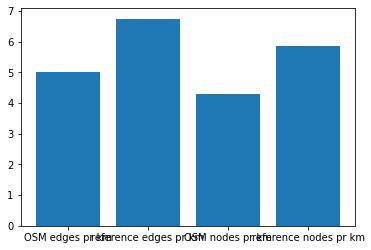

In [17]:
# TODO Number of edges and nodes per network length?

osm_nodes_count = len(osm_simplified_nodes)
osm_edges_count = len(osm_simplified_edges)

ref_nodes_count = len(ref_simplified_nodes)
ref_edges_count = len(ref_simplified_edges)

ref_total_length = ref_simplified_edges.infrastructure_length.sum() / 1000
osm_total_length = osm_simplified_edges.infrastructure_length.sum() / 1000

ref_edges_pr_km = ref_edges_count/ref_total_length
osm_edges_pr_km = osm_edges_count/osm_total_length

ref_nodes_pr_km = ref_nodes_count/ref_total_length
osm_nodes_pr_km = osm_nodes_count/osm_total_length

values = [osm_edges_pr_km, ref_edges_pr_km, osm_nodes_pr_km, ref_nodes_pr_km]
labels = ['OSM edges pr km','reference edges pr km', 'OSM nodes pr km', 'reference nodes pr km']

# TODO format plot
plt.bar(range(len(values)), values, tick_label=labels);


**Alpha, beta and gamma:**

The network metrics alpha, beta and gamma descripe respectively....

Do not say much about the data quality itself. But if they are very similiar for the two networks, despite the network e.g. having very different length this suggests that the data sets have been mapped in roughly the same way - but simply includes way more features in one than the oter. If the networks are roughly the same size but these values differ - indication that network structures are very different.

In [18]:
osm_alpha, osm_beta, osm_gamma = ef.compute_alpha_beta_gamma(osm_simplified_edges, osm_simplified_nodes)

print(f'Alpha for the simplified OSM network is: {osm_alpha:.2f}')
print(f'Beta for the simplified OSM network is: {osm_beta:.2f}')
print(f'Gamma for the simplified OSM network is: {osm_gamma:.2f}')

ref_alpha, ref_beta, ref_gamma = ef.compute_alpha_beta_gamma(ref_simplified_edges, ref_simplified_nodes)

print(f'Alpha for the simplified reference network is: {ref_alpha:.2f}')
print(f'Beta for the simplified reference network is: {ref_beta:.2f}')
print(f'Gamma for the simplified reference network is: {ref_gamma:.2f}')

Alpha for the simplified OSM network is: 0.08
Beta for the simplified OSM network is: 1.16
Gamma for the simplified OSM network is: 0.39
Alpha for the simplified reference network is: 0.08
Beta for the simplified reference network is: 1.15
Gamma for the simplified reference network is: 0.38


**Local node/edge ratio:**

<AxesSubplot:>

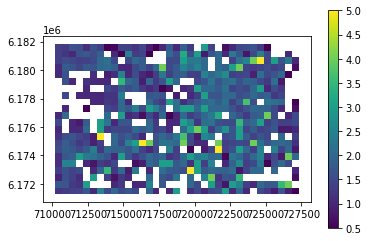

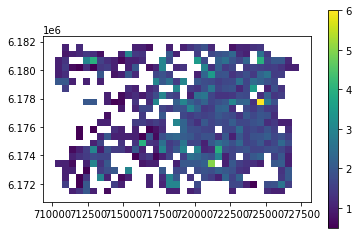

In [19]:

# Per grid cell
results_dict = {}
data = (osm_edges_s_j, osm_nodes_s_j)
[ef.run_grid_analysis(grid_id, data, results_dict, ef.compute_edge_node_ratio) for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df.reset_index(inplace=True)
results_df.rename(columns={'index':'grid_id', 0:'osm_node_edge_ratio'}, inplace=True)

grid = grid.merge(results_df, on='grid_id', how='left')

results_dict = {}
data = (ref_edges_s_j, ref_nodes_s_j)
[ef.run_grid_analysis(grid_id, data, results_dict, ef.compute_edge_node_ratio) for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df.reset_index(inplace=True)
results_df.rename(columns={'index':'grid_id', 0:'ref_node_edge_ratio'}, inplace=True)

grid = grid.merge(results_df, on='grid_id', how='left')


# TODO: Format plotting
grid.plot(column='osm_node_edge_ratio', legend=True);
grid.plot(column='ref_node_edge_ratio', legend=True);


**Number of connected components:**

The OSM network in the study area consists of 334 unconnected components.


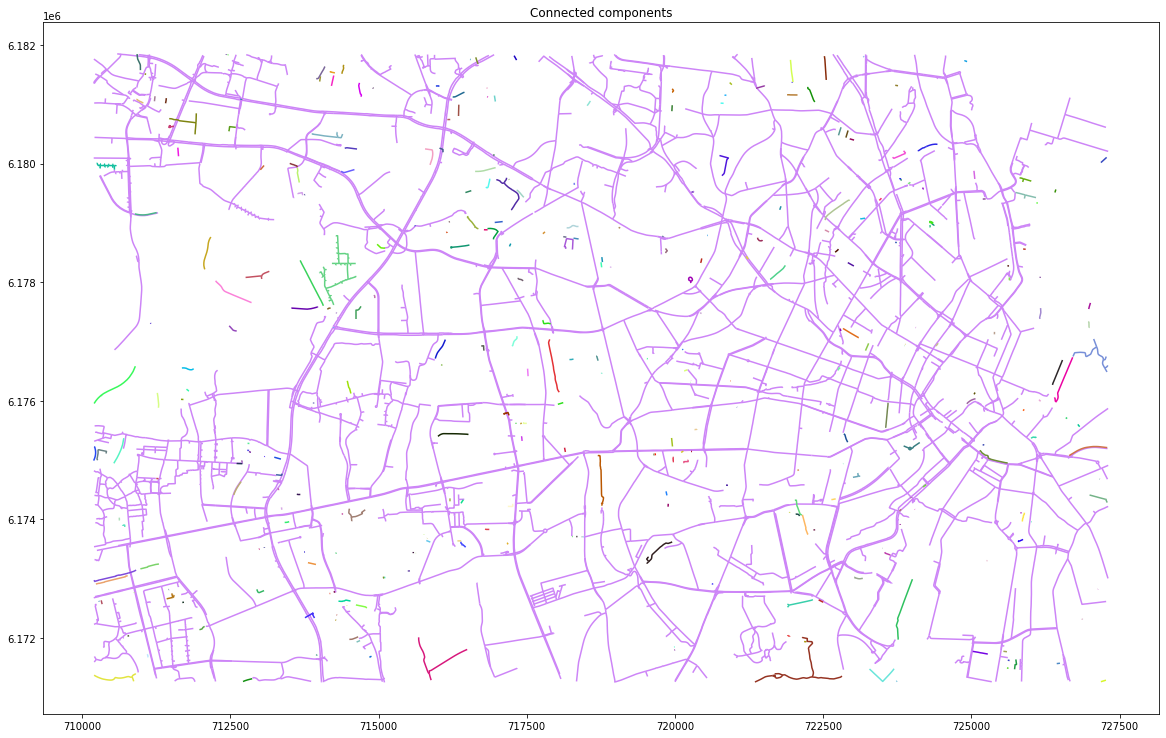

<AxesSubplot:>

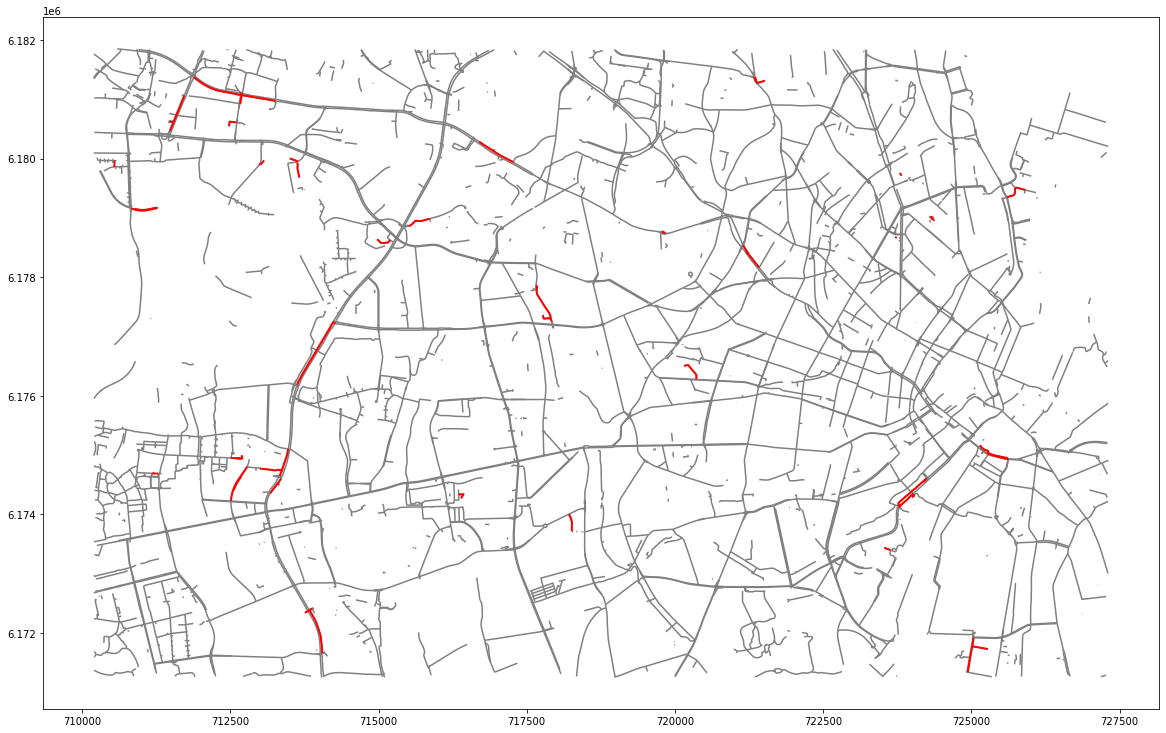

In [20]:
# TODO: Compare plots of unconnected issues!

osm_components = ef.return_components(osm_simplified_graph)
print(f'The OSM network in the study area consists of {len(osm_components)} unconnected components.')

components_plot = ef.plot_components(osm_components)

osm_comp_issues = ef.find_adjacent_components(components=osm_components, buffer_dist=10, crs=study_crs)

fig, ax = plt.subplots(figsize=(20,20))

osm_simplified_edges.plot(ax=ax, color='grey')
osm_comp_issues.plot(ax=ax, color='red', linewidth=2)

# TODO: Fix plot - plot with unconnected components as well

The reference network in the study area consists of 195 unconnected components.


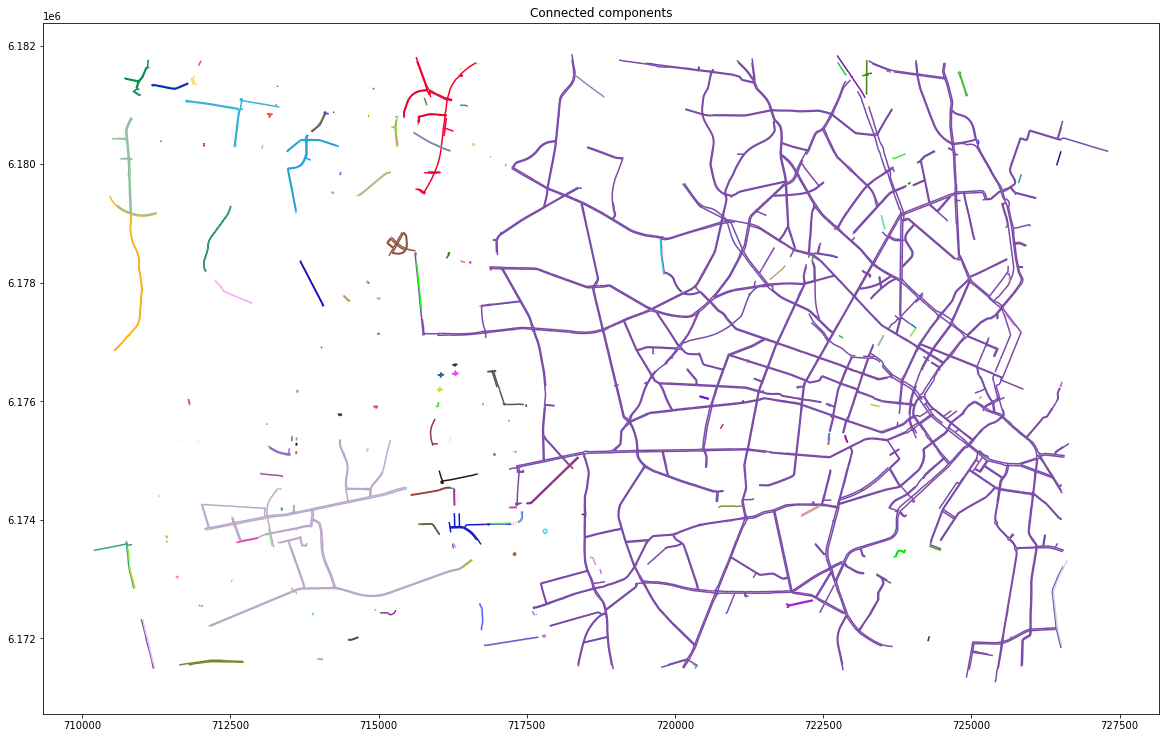

<AxesSubplot:>

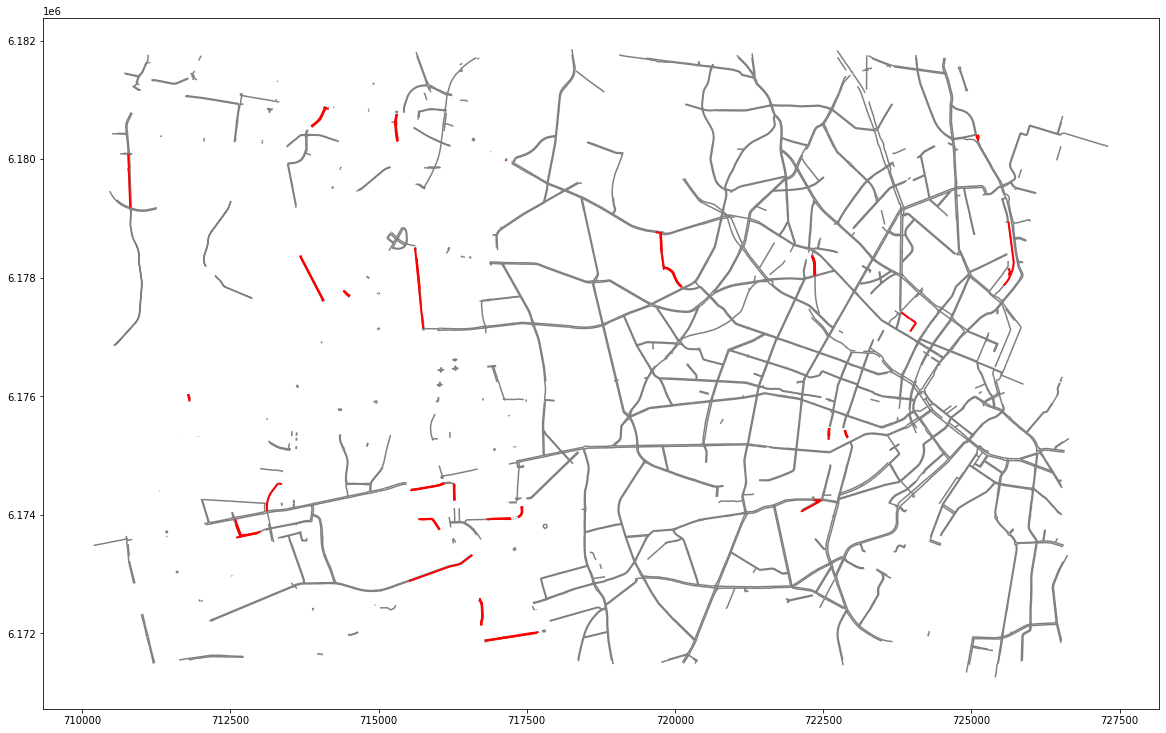

In [21]:
ref_components = ef.return_components(ref_simplified_graph)
print(f'The reference network in the study area consists of {len(ref_components)} unconnected components.')

components_plot = ef.plot_components(ref_components)

ref_comp_issues = ef.find_adjacent_components(components=ref_components, buffer_dist=10, crs=study_crs)

fig, ax = plt.subplots(figsize=(20,20))

ref_simplified_edges.plot(ax=ax, color='grey')
ref_comp_issues.plot(ax=ax, color='red', linewidth=2)

# TODO: Fix plot - plot with unconnected ref_components as well

**Distribution of network length per component:**

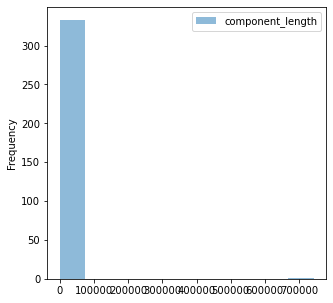

In [22]:
osm_components_df = ef.component_lengths(osm_components)
ax = osm_components_df.plot.hist(column='component_length', bins=10, alpha=0.5, figsize = (5,5))

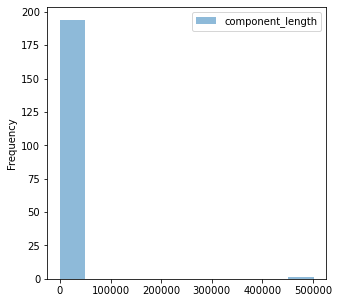

In [23]:
ref_components_df = ef.component_lengths(ref_components)
ax = ref_components_df.plot.hist(column='component_length', bins=10, alpha=0.5, figsize = (5,5))

**Network length in largest connected component:**

In [24]:
osm_largest_cc = max(osm_components, key=len)

osm_largest_cc_length = 0

for (u, v, l) in osm_largest_cc.edges(data='length'):

        osm_largest_cc_length += l

osm_largest_cc_pct = osm_largest_cc_length / osm_components_df['component_length'].sum() * 100

print(f'The largest connected component in the OSM network contains {osm_largest_cc_pct:.2f} % of the network length.')

ref_largest_cc = max(ref_components, key=len)

ref_largest_cc_length = 0

for (u, v, l) in ref_largest_cc.edges(data='length'):

        ref_largest_cc_length += l

ref_largest_cc_pct = ref_largest_cc_length / ref_components_df['component_length'].sum() * 100

print(f'The largest connected component in the reference network contains {ref_largest_cc_pct:.2f} % of the network length.')

# TODO Add plot comparing the two. And maybe plot just the largest ones?

The largest connected component in the OSM network contains 92.82 % of the network length.
The largest connected component in the reference network contains 80.40 % of the network length.


**Ratio of edges to connected components:**

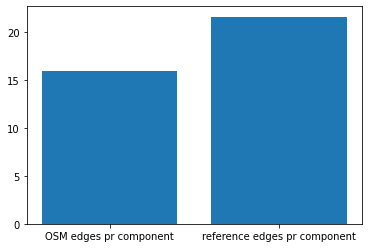

In [25]:
osm_edge_component_ratio =  len(osm_simplified_edges) / len(osm_components)
ref_edge_component_ratio = len(ref_simplified_edges) / len(ref_components)

values = [osm_edge_component_ratio, ref_edge_component_ratio]
labels = ['OSM edges pr component','reference edges pr component']

# TODO format plot
plt.bar(range(len(values)), values, tick_label=labels);

**Assign component id to grid:**

In [26]:
grid = ef.assign_component_id_to_grid(osm_simplified_edges, osm_edges_s_j, osm_components, grid, prefix='osm')

grid = ef.assign_component_id_to_grid(ref_simplified_edges, ref_edges_s_j, ref_components, grid, prefix='ref')

fill_na_dict = {'component_ids_osm': '','component_ids_ref': ''}
grid.fillna(value=fill_na_dict,inplace=True)

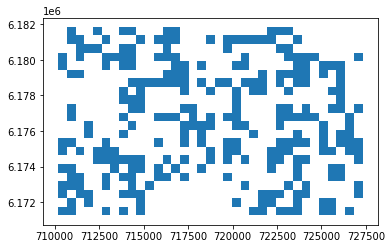

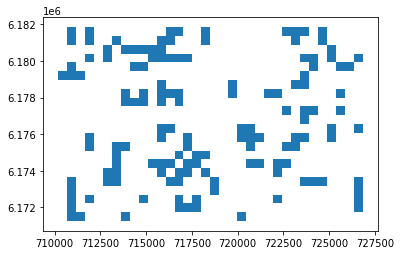

In [31]:
# Cells with more than one component
grid.loc[grid['component_ids_osm'].map(len) > 1].plot();

grid.loc[grid['component_ids_ref'].map(len) > 1].plot();

In [34]:
# TODO:  Plot cells that are connected in one dataset but not in the other

# How to do this? Will be too much with all combinations

# Random samples? Take XXX random cells (but same for both datasets)
# Check how many other cells you can reach from this cell

# Or take random OD cells - see if they are connected using one network or the other
# Highlight differences



**Count and plot all dangling nodes (dead ends):**

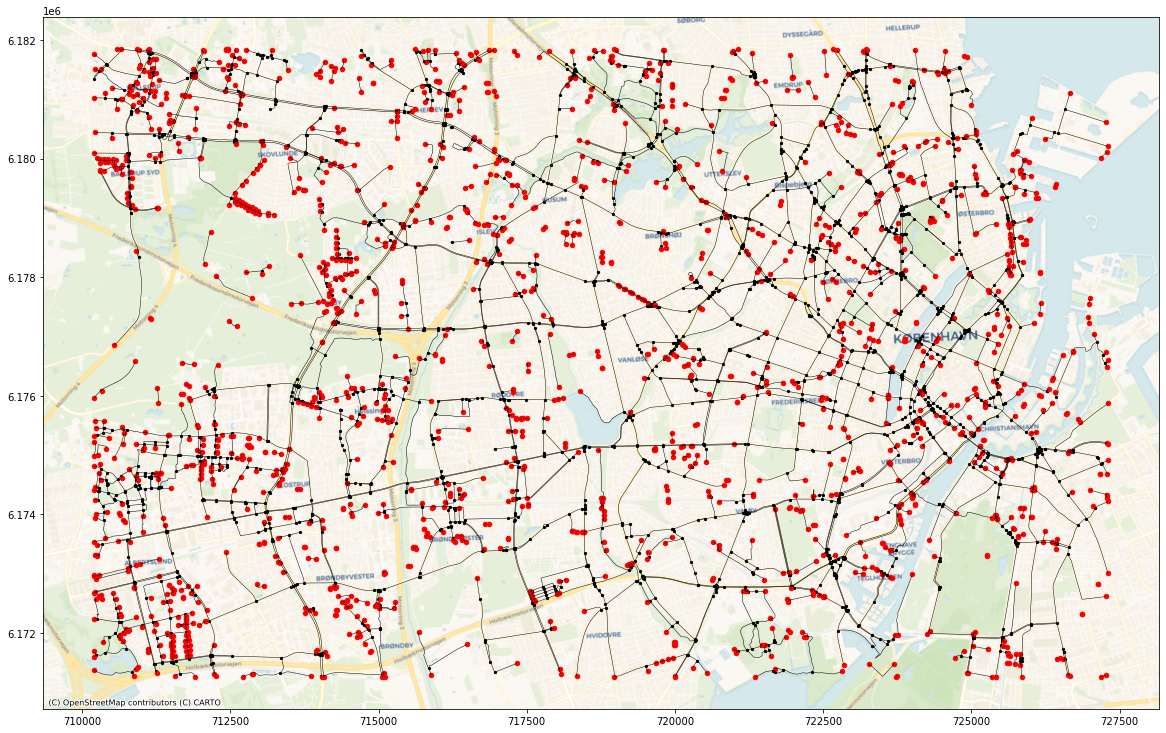

In [22]:
osm_dangling_nodes = ef.get_dangling_nodes(osm_simplified_edges, osm_simplified_nodes)

fig, ax = plt.subplots(1, figsize=(20,20))

osm_simplified_edges.plot(ax=ax, color='black', linewidth=0.5)
osm_simplified_nodes.plot(ax=ax, color='black', markersize=5)
osm_dangling_nodes.plot(ax=ax, color='red', markersize=20)

cx.add_basemap(
        ax, 
        crs=osm_simplified_edges.crs, 
        source=cx.providers.CartoDB.Voyager
    )

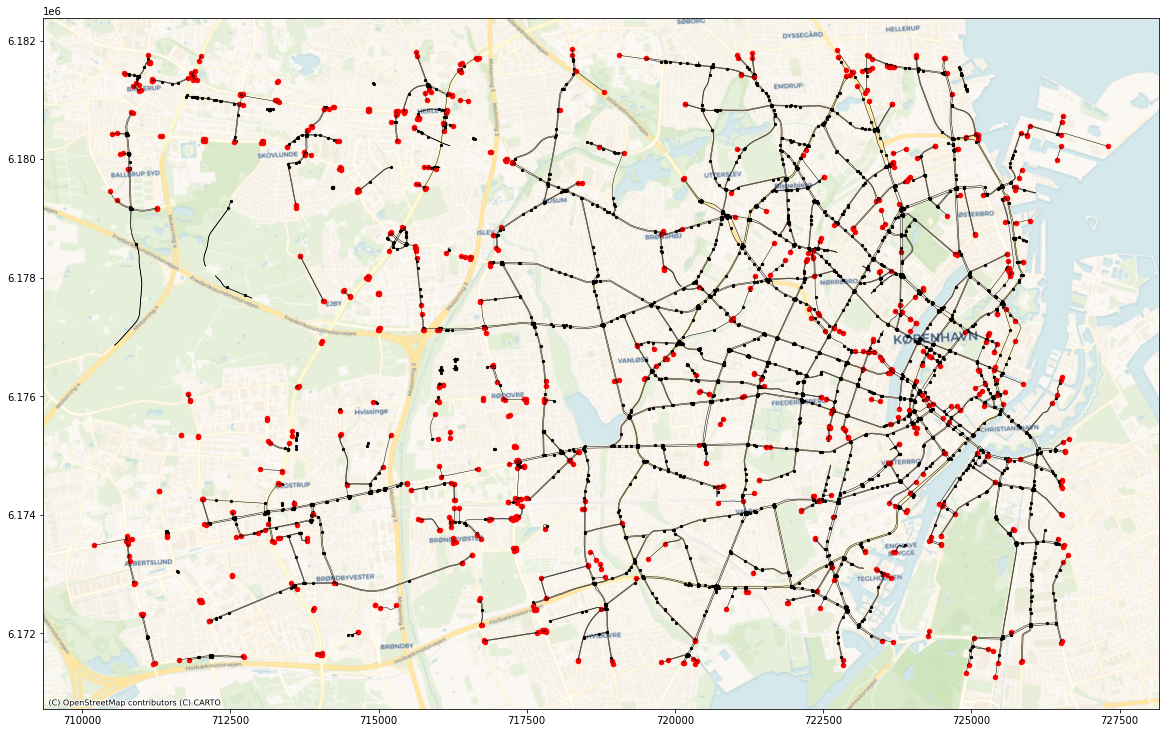

In [23]:
ref_dangling_nodes = ef.get_dangling_nodes(ref_simplified_edges, ref_simplified_nodes)

fig, ax = plt.subplots(1, figsize=(20,20))

ref_simplified_edges.plot(ax=ax, color='black', linewidth=0.5)
ref_simplified_nodes.plot(ax=ax, color='black', markersize=5)
ref_dangling_nodes.plot(ax=ax, color='red', markersize=20)

cx.add_basemap(
        ax, 
        crs=osm_simplified_edges.crs, 
        source=cx.providers.CartoDB.Voyager
    )

**Number of dangling nodes per grid:**

In [70]:
dn_osm_joined = gpd.overlay(osm_dangling_nodes, grid[['geometry','grid_id']], how ='intersection')
df = ef.count_features_in_grid(dn_osm_joined,'osm_dangling_nodes')
grid = grid.merge(df, on='grid_id', how='left')

dn_ref_joined = gpd.overlay(ref_dangling_nodes, grid[['geometry','grid_id']], how ='intersection')
df = ef.count_features_in_grid(dn_ref_joined,'ref_dangling_nodes')
grid = grid.merge(df, on='grid_id', how='left')

grid['osm_dangling_nodes_per_node'] = grid.count_osm_dangling_nodes / grid.count_osm_simplified_nodes
grid['ref_dangling_nodes_per_node'] = grid.count_ref_dangling_nodes / grid.count_ref_simplified_nodes

grid.plot(column='osm_dangling_nodes_per_node',legend=True)
grid.plot(column='ref_dangling_nodes_per_node',legend=True)


**Identifying nodes that are placed within a distance of one meter, but do not share a common edge.**

Based on Barron et al., 2013.


For the OSM data, there are 1 locations where a node is placed within 4 meters of another node without sharing an edge.


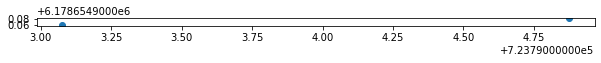

In [35]:
buffer_dist = 4
osm_snapping_issues = ef.find_network_gaps(osm_simplified_nodes, osm_simplified_edges, buffer_dist)

print(f'For the OSM data, there are {len(osm_snapping_issues)} locations where a node is placed within {buffer_dist} meters of another node without sharing an edge.')

if len(osm_snapping_issues) > 0:
    osm_snapping_issues_unpacked = [item for sublist in osm_snapping_issues for item in sublist]

    subset = osm_simplified_nodes.loc[osm_simplified_nodes.node_id.isin(osm_snapping_issues_unpacked)]

    subset.plot(figsize=(10,10))

    # cx.add_basemap(
    #     ax=ax, 
    #     crs=osm_simplified_edges.crs, 
    #     source=cx.providers.CartoDB.Voyager,
    # )


For the reference data, there are 10 locations where a node is placed within 5 meters of another node without sharing an edge.


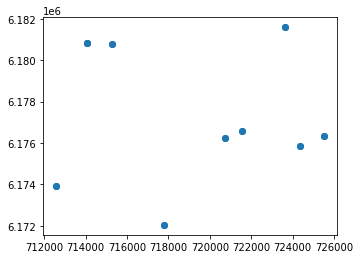

In [50]:
ref_snapping_issues = ef.find_network_gaps(ref_simplified_nodes,ref_simplified_edges, buffer_dist)

print(f'For the reference data, there are {len(ref_snapping_issues)} locations where a node is placed within {buffer_dist} meters of another node without sharing an edge.')

if len(ref_snapping_issues) > 0:

    ref_snapping_issues_unpacked = [item for sublist in ref_snapping_issues for item in sublist]
   
    subset = ref_simplified_nodes.loc[ref_simplified_nodes.node_id.isin(ref_snapping_issues_unpacked)]
    subset.plot()

    # cx.add_basemap(
    #     ax=ax, 
    #     crs=osm_simplified_edges.crs, 
    #     source=cx.providers.CyclOSM,
    # )


## Feature Matching

- Matched and non-matched edges - total and per grid cell (count or length?)
- Comparison of matched edges - do they aggree on core attributes?


What are core attributes? I am thinking whether it is lane/track? One or two-way - but how to account for differing digitising methods? Maybe protected/unprotected is enough?

For this - needs to be translated in the data attribute values

In [ ]:
if feature_matching:
    pass

In [48]:
# Segmentize
osm_segments = mf.create_segment_gdf(osm_simplified_edges, segment_length=10)
osm_segments.rename(columns={'osmid':'org_osmid'}, inplace=True)
osm_segments.rename(columns={'seg_id':'osmid'}, inplace=True) # Because function assumes an id column names osmid
osm_segments.set_crs(study_crs, inplace=True)
osm_segments.dropna(subset=['geometry'],inplace=True)

ref_segments = mf.create_segment_gdf(ref_simplified_edges, segment_length=10)
ref_segments.set_crs(study_crs, inplace=True)
ref_segments.dropna(subset=['geometry'],inplace=True)

In [49]:
buffer_matches = mf.overlay_buffer(reference_data=ref_segments, osm_data=osm_segments, ref_id_col='seg_id', dist=15)

In [50]:
final_matches = mf.find_matches_from_buffer(buffer_matches=buffer_matches, osm_edges=osm_segments, reference_data=ref_segments, angular_threshold=30, hausdorff_threshold=17)

In [ ]:
final_matches.plot()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

osm_simplified_edges.plot(ax=ax)

final_matches.plot(ax=ax, color='red')

In [ ]:

osm_updated = mf.update_osm(osm_segments=osm_segments, osm_data=osm_edges, final_matches=final_matches, attr='vejklasse')

osm_updated.plot()


In [ ]:
# Matched and non-matched edges - total and per grid cell

In [ ]:
# TODO: Save results

all_results_ref = {}
all_results_osm = {}

# Add dictionary with results from existing tags count, incompatible tags, count intersection issues, snapping issues, danling node count, simplification outcome
# components (number of components, size distribution, issues with close unconnected components)

with open(f'../data/extrinsic_analysis_ref_{study_area}.json', 'w') as outfile:
    json.dump(all_results_ref, outfile)

with open(f'../data/extrinsic_analysis_osm_{study_area}.json', 'w') as outfile:
    json.dump(all_results_ref, outfile)

# Save grid with results
grid.to_file(f'')

In [ ]:
# TODO: Save results

all_results = {}

# Add dictionary with results from existing tags count, incompatible tags, count intersection issues, snapping issues, dangling node count, simplification outcome
# components (number of components, size distribution, issues with close unconnected components)

all_results['existing_tags'] = existing_tags_results
all_results['incompatible_tags'] = incompatible_tags_results
all_results['network_density'] = density_results
all_results['count_intersection_issues'] = count_intersection_issues
all_results['snapping_issues'] = osm_snapping_issues
all_results['dangling_node_cout'] = len(dangling_nodes)
all_results['simplification_outcome'] = simplification_results
all_results['component_analysis'] = components_results

with open(f'../data/osm_instrinsic_analysis_{study_area}.json', 'w') as outfile:
    json.dump(all_results, outfile)

# Save grid with results